# Classifying cardiomyopathy v. coronary artery disease for patients with and without vectorized text data


A Ram, Jason Liu, Saejeong Park, Sarah Dudgeon


## Here's the basic outline of our project.

* We input subject ids and their associated ICD9 codes, NOTEEVENTS data and processed LABEVENTS ["non-text"] data
* We extract the most recent notes for each patient and run [Doc2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html) to create vectors out of each patient's most recent notes
  * We consolidate this into a "text data" matrix
* We combine the text and non-text data matrices by subject id into a new "text+non-text" data matrix
* We generate labels for text, non-text and text+non-text data matrices based on each patient's ICD9 codes
* We classify using GLM [logistic regression], decision tree, SVM, random forest and majority vote
  * We run GLM and decision tree with [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) to see if this will improve performance
  * We run majority vote to see if a consensus approach will improve performance. We use all other classifiers for the vote, namely:
    * GLM 
    * GLM with boosting
    * Decision tree
    * Decision tree with boosting
    * SVM
    * Random forest
* We run k-fold cross validation [k=10] to more robustly assess classifier accuracy beyond counting misclassified points
* We generate ROC curves/AUC for each classifier to provide another estimate of performance beyond accuracy 
* We check feature importance [when possible, not all models, like SVM with nonlinear kernel, allow] to better understand why our model performance is often not great 


**Input files:**

* ```SubID_ICD_Disease.csv```, which isolates patients with our ICD codes of interest [generated from ```SubID_ICD_Diseases.ipynb```]

* ```nontext/labevents2_processed_matrix.csv```, which takes the "most recent" LABEVENTS data for each patient and processes into a matrix [generated from ```nontext/mimic_processing.Rmd```]

* ```NOTEEVENTS.csv```, which is just MIMIC ```NOTEEVENTS```` data

**Outputs:**

* ```noteevents_most_recent.csv```, which contains NOTEEVENTS data and document vectors for each patient
* ```textdatamat.csv```, which contains document vectors for each patient [csv form of ```textDataMat```]
* ```filledna_processed_nontext.csv```, which contains imputed ```LABEVENTS``` data for each patient [csv form of ```filledna_processed_nontext```]
* ```text_nontext_data.csv```, which is a merge of the data ```textdatamat.csv``` and ```filledna_processed_nontext.csv``` [csv form of ```textNontextData```] 

* Three matrices with text, non-text and text+non-text data: 
  * ```textDataMat```, which contains document vectors for each patient

  * ```filledna_processed_nontext```, which contains imputed ```LABEVENTS``` information for each patient
  * ```textNontextData```, which is just the merge of ```textDataMat``` and ```filledna_processed_nontext```





## First we'll mount our drive and import all salient libraries.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd

# for vectorization of text
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')
from tqdm import tqdm

# for doc2vec, to expedite runtime
import multiprocessing

# to separate the data into train/test sets
from sklearn.model_selection import train_test_split

# for k-fold validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# for GLM
from sklearn.linear_model import LogisticRegression

# for decision tree
from sklearn import tree

# for svm
from sklearn import svm

# for random forest and majority vote
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# for adaboost
from sklearn.ensemble import AdaBoostClassifier

# for roc/auc scores
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics

# for plotting
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Next, let's import our data and do some preliminary processing 

We've already done some of the preprocessing in the script ```SubID_ICD_Diseases.ipynb```. Very quickly, here's what we did: 

1. Import data from MIMIC-II tables ```D_ICD_DIAGNOSES``` and ```DIAGNOSES_ICD```
2. Find ICD-9 codes for "cardiomyopath" and "atherosclerosis" in ```D_ICD_DIAGNOSES```
3. Select rows for patients with the resulting ICD-9 codes in ```DIAGNOSES_ICD```:
  
  1. [425.11](http://www.icd9data.com/2014/Volume1/390-459/420-429/425/425.11.htm), [425.18](http://www.icd9data.com/2014/Volume1/390-459/420-429/425/425.18.htm) and [425.4](http://www.icd9data.com/2014/Volume1/390-459/420-429/425/425.4.htm) for cardiomyopathy
  2. [440.29](http://www.icd9data.com/2014/Volume1/390-459/440-449/440/440.29.htm), [440.9](http://www.icd9data.com/2014/Volume1/390-459/440-449/440/440.9.htm), [414.01](http://www.icd9data.com/2014/Volume1/390-459/410-414/414/414.01.htm) and [414.3](http://www.icd9data.com/2014/Volume1/390-459/410-414/414/414.3.htm) for coronary artery disease
4. Combined all into ```SubID_ICD_Disease.csv```. 


From here we read in that csv file along with MIMIC's ```NOTEEVENTS```.

As for the ```LABEVENTS``` data matrix -- we process the data in ```nontext/mimic_processing.R``` and export to ```labevents_processed_matrix.csv```. This data matrix contains all ```LABEVENTS``` data for our patients of interest. We'll use it for classification purposes. 





In [42]:
# read in saejeong's subject_id with icd codes
data = pd.read_csv('/content/drive/MyDrive/cbb 750 final/SubID_ICD_Disease.csv')

# read in jason's LABEVENTS data matrix
nontext = pd.read_csv("/content/drive/MyDrive/cbb 750 final/nontext/labevents2_processed_matrix.csv")

# read in NOTEEVENTS from mimic--can take up to 2 mins!
notes = pd.read_csv('/content/drive/MyDrive/cbb 750 final/mimic/NOTEEVENTS.csv')

### Extracting the most recent notes for each patient


Now, our goal is to find text notes for all patients in ```SubID_ICD_Disease.csv```. Specifically, we want to find the most recent text notes for each patient, which should hopefully be the most salient to determining their disease state. [The assumption is that earlier patient notes may include data that's completely extraneous to our classification task, which in turn will make classification harder.]

We realized that the ```CHARTDATE``` column [which represents when the notes were recorded] was the only reliable indicator of time here [others are frequently NA whereas this appears to have a value in all rows], and even then it outputs things in a weird format. Ostensibly it is in "year-date-month" but the years are... in the future? 

Here's an example: 
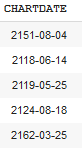

We're unsure as to why this is the case but we sorted based on "most recent date." Here's how: 

1. Since these "dates" are stored as strings, we first strip "-" and convert to ints. We store that in a new column called ```DATETOUSE```. 
2. We get a list of unique ```SUBJECT_ID```s. This is easily done using python's set operations.
3. We create a new empty dataframe called ```uniqueNotes``` with the same columns as ```NOTEEVENTS```. It will become a subset of rows in ```NOTEEVENTS```, namely all rows containing the "most recent" note for each unique patient.
4. We iterate over each unique patient, find the notes associated with them and find the row corresponding to the "most recent" one. 
  * Finding the "most recent" date just means finding the max of all ```DATETOUSE``` values associated with this patient. 
5. We then add that row to ```uniqueNotes``` and export as ```noteevents_most_recent.csv```
  * I know exporting is not strictly necessary but we may want to work on the data in a different notebook/script. 

In [ ]:
# merge icd codes with NOTEEVENTS
subjectNotes = pd.merge(data, notes, on="SUBJECT_ID")

# create a new column DATETOUSE, which gets rid of the hyphens in CHARTDATE strings and converts to int
subjectNotes['DATETOUSE'] = subjectNotes['CHARTDATE'].map(lambda CHARTDATE: int(CHARTDATE.replace('-','')))

# see which patients have multiple notes: see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html
duplicates = subjectNotes[subjectNotes.duplicated(subset=["SUBJECT_ID"])]

# find the unique subject ids--we have to make it a list else python will throw an error later
uniqueIDs = list(set(duplicates['SUBJECT_ID']))

# create a new dataframe for the unique notes with the same columns as subjectnotes
uniqueNotes = pd.DataFrame(columns=subjectNotes.columns)

# go through the unique subject ids and find the most recent notes for each patient 
for i in range(len(uniqueIDs)):

  id = uniqueIDs[i]

  # find notes associated with a given subjectid
  assocNotes = subjectNotes.loc[subjectNotes['SUBJECT_ID'].isin([id])]

  # now we'll get the max value of all DATETOUSE values associated with each patient [idxmax gives you the row index]
  # for idxmax info see here: https://www.kite.com/python/answers/how-to-find-the-max-value-of-a-pandas-dataframe-column-in-python
  date = assocNotes['DATETOUSE']
  chartMaxInd = date.idxmax()

  # extract that row--the index we get is from subjectNotes since assocNotes is a subset of subjectNotes, not its own dataframe 
  chartMax = subjectNotes.iloc[chartMaxInd,:]
  
  # chartMax is a series, which we need to convert to a dataframe. It is also transposed from the original for some reason so we need to transpose it back
  maxRow = chartMax.to_frame().T

  # add it on to uniqueNotes
  uniqueNotes = pd.concat([uniqueNotes, maxRow])


uniqueNotes.head()

,Unnamed: 0,SUBJECT_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE,ROW_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,DATETOUSE
475330,12232,3,4254,Prim cardiomyopathy NEC,Other primary cardiomyopathies,784268,NaN,2102-04-18,2102-04-18 13:22:00,NaN,Radiology,ART DUP EXT LO UNI;F/U,NaN,NaN,[**2102-4-18**] 1:22 PM\n ART DUP EXT LO UNI;F...,21020418
427689,10946,32773,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,34384,129856,2185-10-05,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2185-9-26**] ...,21851005
67171,1413,98310,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,129334,NaN,2175-05-17,NaN,NaN,ECG,Report,NaN,NaN,Baseline artifact\nVentricular paced rhythm\nI...,21750517
245933,6167,32777,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,220354,NaN,2113-11-18,NaN,NaN,ECG,Report,NaN,NaN,Normal sinus rhythm with marked A-V conduction...,21131118
905,25,32779,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,37,133757,2167-10-27,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2167-10-20**] ...,21671027


##### Type of notes used for text-based classification

The ```NOTEEVENTS``` table places each note into a specific category under the column ```CATEGORY```. Let's take a look at the distribution of notes in our text data. 

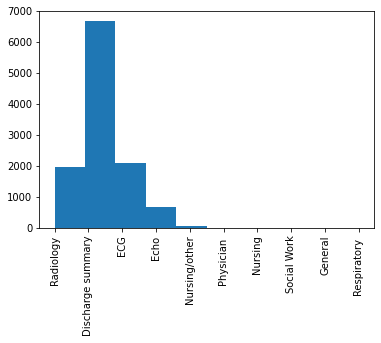

<Figure size 432x288 with 0 Axes>

In [ ]:
# make a histogram of the CATEGORY column of the uniqueNotes
p = plt.hist(uniqueNotes['CATEGORY'])

# rotate x-axis names so they fit nicely on the page
plt.xticks(rotation='vertical') 

plt.show()
plt.xlabel()
plt.savefig('hist_noteCategory')

## Now we can conduct NLP on the text data matrix.

Now that we have our data matrix set up, we'll normalize the text, remove stop words, and vectorize the data using doc2vec. We do this to get into the same form as the LABEVENTS matrix and to use it for classification.

In [ ]:
# extract the column: 'TEXT' - save as variable: 'textData'
textData = uniqueNotes['TEXT']

# check my work - print the checks
print(len(textData)) #each row = 1 document, length of vector = number documents
textData[0:4] #scope the scene - view the first five documents

11572


475330    [**2102-4-18**] 1:22 PM\n ART DUP EXT LO UNI;F...
427689    Admission Date:  [**2185-9-26**]              ...
67171     Baseline artifact\nVentricular paced rhythm\nI...
245933    Normal sinus rhythm with marked A-V conduction...
Name: TEXT, dtype: object

### Text Processing

Explain what is being done here

In [ ]:
#clean the data
def cleanText(text):
    text = text.lower() #normalize
    ## can add other text processing commands here 
    return text

#apply the cleanText function to the text data
cleanTextData = textData.apply(cleanText)

# tokenize the data
tokenTextData = [nltk.word_tokenize(row) for row in cleanTextData] 

# check that it worked
print('original:', textData[0])
print('cleaned:', cleanTextData[0])
print('tokenized:', tokenTextData[0])

original: Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]


Service:
ADDENDUM:

RADIOLOGIC STUDIES:  Radiologic studies also included a chest
CT, which confirmed cavitary lesions in the left lung apex
consistent with infectious process/tuberculosis.  This also
moderate-sized left pleural effusion.

HEAD CT:  Head CT showed no intracranial hemorrhage or mass
effect, but old infarction consistent with past medical
history.

ABDOMINAL CT:  Abdominal CT showed lesions of
T10 and sacrum most likely secondary to osteoporosis. These can
be followed by repeat imaging as an outpatient.



                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]

Dictated By:[**Hospital 1807**]
MEDQUIST36

D:  [**2151-8-5**]  12:11
T:  [**2151-8-5**]  12:21
JOB#:  [**Job Number 1808**]

cleaned: admission date:  [**2151-7-16**]       discharge date:  [**2151-8-4**]


service:
addendum:

### Tag the Processed Text

Now we need to tag the documents because the vectorizor likes to ingest data this way. 

There are many ways to experiment here: 

*   We can tag the documents with the labels (as performed below)
*   We can tag the documents with unique identifiers, to train our vectorizer to know that each document is unique
*   We can tag the documents with multiple labels, a combination of the two examples above or use other factors from the dataframe. In adding more data to the tags, we may increase predictability of our resulting vectors.


#### Make labels for tagging

Unfortunately this block of code is used multiple times throughout the notebook. For now we recognize the redundancy. It gets the job done and will have to do.  

Here's how we generate labels: 

* We find each patient's ICD9 code [under column ```ICD9_CODE``` in uniqueNotes]
* Label cardiomyopathy ICD codes as 0 and CAD as 1
  *   Cardiomyopathy codes are  [425.11](http://www.icd9data.com/2014/Volume1/390-459/420-429/425/425.11.htm), [425.18](http://www.icd9data.com/2014/Volume1/390-459/420-429/425/425.18.htm) and [425.4](http://www.icd9data.com/2014/Volume1/390-459/420-429/425/425.4.htm) 
  * CAD codes are [440.29](http://www.icd9data.com/2014/Volume1/390-459/440-449/440/440.29.htm), [440.9](http://www.icd9data.com/2014/Volume1/390-459/440-449/440/440.9.htm), [414.01](http://www.icd9data.com/2014/Volume1/390-459/410-414/414/414.01.htm) and [414.3](http://www.icd9data.com/2014/Volume1/390-459/410-414/414/414.3.htm) 

* Add all labels to the array ```tagging_labels```

In [ ]:
# let's make the labels--basically we want to separate out by icd code
# we'll make 0=cardiomyopathy, 1=CAD
cm = [42511, 42518, 4254]
cad = [44029, 4409, 41401, 4143]

# this array contains all the ICD codes in order
codes = uniqueNotes['ICD9_CODE'].tolist()

# this array will contain all the data labels in order
tagging_labels = []

# iterate through the rows of textVectorMat and create labels 
for i in range(len(codes)):

  # grab the icd code from row i
  icd = codes[i]

  # if the icd code is a CM one, append 0 to labels, else if it's CAD append 1
  if icd in cm: 
    tagging_labels.append(0)
  else: 
    tagging_labels.append(1)

# ensure that the length of the list of labels is the same as the length of codes
print("labels:", len(tagging_labels))
print("codes:", len(codes))

labels: 11572
codes: 11572


#### Perform the tagging

Explain what this entails

In [ ]:
# initialize the array 
documents = []

# tag each document with the associated label
for i in range(len(tokenTextData)):
  taggedDoc = TaggedDocument(words=tokenTextData[i], tags=[tagging_labels[i]])
  documents.append(taggedDoc)

# check that it worked
print('tagged:', documents[0])

NameError: ignored

### Vectorizing with Doc2Vec

Now we will build a vectorizer using the Doc2Vec model.

We will split the tagged data into train and test with a 70-30 train-test split. Train data will be used to train the vectorizer and we'll be using that same 70-30 train-test split when running our models, just to keep things consistent. 

In [ ]:
# split into train and test
trainDocuments, testDocuments = train_test_split(documents, test_size=0.3, random_state=42)

# check our work:
print(len(documents))
print(len(trainDocuments))
print(len(testDocuments))
print(trainDocuments[10]) # printing a random trainDocument to check formatting

11572
8100
3472
TaggedDocument(['[', '**2136-3-6**', ']', '8:30', 'am', 'ct', 'chest', 'w/o', 'contrast', 'clip', '#', '[', '**clip', 'number', '(', 'radiology', ')', '77439**', ']', 'reason', ':', 'f/u', 'left', 'upper', '[', '**clip', 'number', '(', 'radiology', ')', '**', ']', ';', 'lung', 'ca', '______________________________________________________________________________', '[', '**hospital', '2**', ']', 'medical', 'condition', ':', '83', 'year', 'old', 'man', 'with', 'left', 'upper', '[', '**hospital', '1618**', ']', 'nodule', 'reason', 'for', 'this', 'examination', ':', 'followup', 'left', 'upper', '[', '**hospital', '1618**', ']', 'nodule', ',', 'please', 'compare', 'to', 'prior', 'studies', 'no', 'contraindications', 'for', 'iv', 'contrast', '______________________________________________________________________________', 'final', 'report', 'ct', 'chest', 'without', 'contrast', 'dated', '[', '**2136-3-6**', ']', 'comparison', ':', '[', '**2135-8-29**', ']', 'chest', 'cta', '.'

After splitting the tagged data, we'll do the following: 
  
  * Build the model and input model parameters
  * Build the vocabulary that will be used in the model
    * The vocabulary is based on every token in the entire corpus of train documents.

Importantly, we make the document vector size **438**, which is the same number of features as the nontext matrix [minus the subject_id column]. This helps facilitate comparison between the two models. 

In [ ]:
# To run a parallelized approach, we count our processing cores
# This significantly expedites runtime
cores = multiprocessing.cpu_count()

# initialize the model
doc2VecModel = Doc2Vec(dm=1, # using the Paragraph Vector-Distributed Memory (PV-DM) model, similar to CBOW in word2vec
                vector_size=438, # size of each vector, 1 vector per document
                window=10, # number of surrounding tokens impacting each token's weight
                negative=5, hs=0, min_count=1, # minimum acceptances
                workers=cores, # off for now, using the cores found for parallelized approach described above.
                alpha=0.025, min_alpha=0.001) # learning rates

# build vocab
doc2VecModel.build_vocab([x for x in tqdm(trainDocuments)])

100%|██████████| 8100/8100 [00:00<00:00, 1201721.28it/s]


Lets train the model:

We'll record the time just so we know about how long everything takes. We run for 10 epochs, which is a [standard](https://radimrehurek.com/gensim/models/doc2vec.html) value. This will take a while--roughly ~32-34 minutes when we've run it!

In [ ]:
# record the time -> usually takes about 30 minutes
%%time

# run the model with 10 epochs
for epoch in range(10):
    print('iteration {0}'.format(epoch))
    doc2VecModel.train(utils.shuffle([x for x in tqdm(trainDocuments)]), total_examples=len(trainDocuments), epochs=doc2VecModel.iter)
    #doc2VecModel.alpha -= 0.002
    #doc2VecModel.min_alpha = doc2VecModel.alpha


# save the model to use at a later date:
#doc2VecModel.save("d2v.model")
#print("Model Saved")

100%|██████████| 8100/8100 [00:00<00:00, 736512.80it/s]

iteration 0



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """
100%|██████████| 8100/8100 [00:00<00:00, 1010044.67it/s]

iteration 1



100%|██████████| 8100/8100 [00:00<00:00, 733792.57it/s]

iteration 2



100%|██████████| 8100/8100 [00:00<00:00, 1098659.97it/s]

iteration 3



100%|██████████| 8100/8100 [00:00<00:00, 1957809.16it/s]

iteration 4



100%|██████████| 8100/8100 [00:00<00:00, 1945254.07it/s]

iteration 5



100%|██████████| 8100/8100 [00:00<00:00, 1155770.11it/s]

iteration 6



100%|██████████| 8100/8100 [00:00<00:00, 1096390.82it/s]

iteration 7



100%|██████████| 8100/8100 [00:00<00:00, 1646818.34it/s]

iteration 8



100%|██████████| 8100/8100 [00:00<00:00, 1164724.96it/s]

iteration 9


CPU times: user 1h 1min 34s, sys: 13.2 s, total: 1h 1min 47s
Wall time: 32min 9s


We'll use the trained model to create vectors for the corpus. 

We'll store the vectors in a list of vectors, which we may then add to our dataframe as a new column of data.

In [ ]:
# initialize an empty vector
docVectors = []

# for each tokenized document, use the model to infer a vector, store the vector in 'docVectors'
for i in range(len(tokenTextData)):
  vec = doc2VecModel.infer_vector(tokenTextData[i])
  docVectors.append(vec)


#   sanity check
print(len(docVectors)) # should be same length as number of unique patients/length of corpus
print(len(docVectors[0])) # should be same length as the vector_size input into the doc2vec model
print(docVectors[0])

11572
438
[ 0.08961867  0.05225237 -0.02182593 -0.1325062  -0.04235648  0.02031939
 -0.08463685  0.04356737  0.08568966  0.10413086 -0.21926095 -0.00684133
 -0.01473457 -0.13951817 -0.12634423 -0.03330374 -0.1431566   0.06908908
  0.0303576  -0.04515759 -0.01950812  0.10817665 -0.03878772  0.03911992
 -0.09959868  0.0362013   0.06340539  0.127625   -0.11943384  0.06101257
  0.06145218  0.04829501 -0.01267216  0.10782479  0.02743006 -0.06273396
 -0.11657942 -0.23513135  0.18746036  0.01065594 -0.26709786  0.04581324
  0.0941978   0.3220771  -0.00433553 -0.17525579  0.03197254 -0.18911512
  0.02110042 -0.23297629  0.2148378   0.20676813  0.14064737 -0.09921738
 -0.03083138 -0.02958974  0.21416457  0.23716375  0.02600233 -0.16001174
 -0.20877701  0.0783632   0.21053301 -0.05782223 -0.24427009 -0.12009718
  0.0107403  -0.11264966 -0.03861984 -0.09781489 -0.00978167  0.10278507
 -0.13497302  0.09719813 -0.06187553 -0.09187638 -0.06818846 -0.08530002
  0.05947986 -0.00988815  0.08655977 -0.1

Let's save these document vectors as a new column in the dataframe uniqueNotes. 

In [ ]:
#add vectors to uniqueNotes
uniqueNotes["DOC_VECTORS"] = docVectors

# check our work
uniqueNotes.head()

,Unnamed: 0,Unnamed: 0.1,SUBJECT_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE,ROW_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,DATETOUSE,LABELS,DOC_VECTORS
0,475330,12232,3,4254,Prim cardiomyopathy NEC,Other primary cardiomyopathies,784268,NaN,2102-04-18,2102-04-18 13:22:00,NaN,Radiology,ART DUP EXT LO UNI;F/U,NaN,NaN,[**2102-4-18**] 1:22 PM\n ART DUP EXT LO UNI;F...,21020418,0,"[0.08961867, 0.052252375, -0.021825928, -0.132..."
1,427689,10946,32773,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,34384,129856.0,2185-10-05,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2185-9-26**] ...,21851005,1,"[0.037899565, 1.2805989, -1.1988019, 0.2361796..."
2,67171,1413,98310,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,129334,NaN,2175-05-17,NaN,NaN,ECG,Report,NaN,NaN,Baseline artifact\nVentricular paced rhythm\nI...,21750517,1,"[0.024404855, 0.060916033, -0.026240427, 0.021..."
3,245933,6167,32777,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,220354,NaN,2113-11-18,NaN,NaN,ECG,Report,NaN,NaN,Normal sinus rhythm with marked A-V conduction...,21131118,1,"[-0.058894467, 0.12551542, -0.17900251, -0.047..."
4,905,25,32779,41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,37,133757.0,2167-10-27,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2167-10-20**] ...,21671027,1,"[0.29772723, 0.7641294, -0.79556525, 0.1366110..."


Finally, we'll just save uniqueNotes as a csv.

In [ ]:
uniqueNotes.to_csv("/content/drive/MyDrive/cbb 750 final/noteevents_most_recent.csv")

## We are now equipped to generate labels for text and non-text data. 

[**OPTIONAL CODE BLOCK**] I use this so we don't have to run through the vectorization etc [which takes a long tme] every time I want to classify. 

In [43]:
uniqueNotes = pd.read_csv("/content/drive/MyDrive/cbb 750 final/noteevents_most_recent.csv")

### Reformatting the document vectors

The doc vectors are formatted as strings, e.g. ```"[1 2\n 3]"``` so I need to convert into an actual list that I can use for classification. Here's what I do:


1.   Split by " ": ```["[1","","2\n","","3]"]```
2.   Remove ```""``` and ```\n```: ```["[1","2","3]"]```
3.   Remove ```"["```,```"]"```: ```["1","2","3"]```
4.   Convert all numbers into floats: ```[1,2,3]```

After that, we add in subjectids and icd9 codes for each patient, both pulled from the dataframe ```uniqueNotes```. In total we get a df with subjectid, doc vectors and icd9 code. 

And yes -- we could've used ```docVectors``` here instead of making ```vectorList```, or even bothering to save the ```uniqueNotes``` csv earlier. However, since that would require us to run the doc2Vec step every time we opened the notebook we decided to take a more redundant but less time-intensive approach. 





In [44]:
# grab doc vectors from the textdata df and place them in a lst
vectorlist = uniqueNotes['DOC_VECTORS'].tolist()

# process the first vector separately -- this is just to initialize a df that we can append to later

# split by " "
splitvector = vectorlist[0].split(' ')

# remove \n, [ and ]
sv = [s.strip('\n') for s in splitvector] 
sv = [s.strip('[') for s in sv] 
sv = [s.strip(']') for s in sv]

# remove ''
sv = list(filter(None, sv))

# convert into floats
sv = [float(i) for i in sv]

# add subjectid for row 0
subid = uniqueNotes.loc[0,'SUBJECT_ID']

# insert subjectid at the beginning of sv
sv.insert(0,subid)

# convert into a df -- we have to transpose so each row represents a subjectID
docMatrix = pd.DataFrame(sv).T

# we want that first column to be named SUBJECT_ID
docMatrix.rename(columns={0: 'SUBJECT_ID'}, inplace=True)

# now we can do it for the rest of the matrices

for i in range(1,len(vectorlist)):

  # split by " "
  splitvector = vectorlist[i].split(' ')

  # remove \n, [ and ]
  sv = [s.strip('\n') for s in splitvector] 
  sv = [s.strip('[') for s in sv] 
  sv = [s.strip(']') for s in sv]

  # remove ''
  sv = list(filter(None, sv))

  # convert into floats
  sv = [float(i) for i in sv]

  # add subjectid for row i
  subid = uniqueNotes.loc[i,'SUBJECT_ID']

  # insert subjectid at the beginning of sv
  sv.insert(0,subid)

  # convert into a df -- we have to transpose so each row represents a subjectID
  docvectordf = pd.DataFrame(sv).T

  # we want that first column to be named SUBJECT_ID
  docvectordf.rename(columns={0: 'SUBJECT_ID'}, inplace=True)

  # concatenate with docMatrix
  docMatrix = pd.concat([docMatrix, docvectordf])


# add in icd9 codes--we only want subject_id and icd9 code
subIcd = uniqueNotes[['SUBJECT_ID','ICD9_CODE']]

textVectorMat = pd.merge(docMatrix, subIcd, on='SUBJECT_ID')
textVectorMat.head()

,SUBJECT_ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,ICD9_CODE
0,3.0,0.089619,0.052252,-0.021826,-0.132506,-0.042356,0.020319,-0.084637,0.043567,0.085690,0.104131,-0.219261,-0.006841,-0.014735,-0.139518,-0.126344,-0.033304,-0.143157,0.069089,0.030358,-0.045158,-0.019508,0.108177,-0.038788,0.039120,-0.099599,0.036201,0.063405,0.127625,-0.119434,0.061013,0.061452,0.048295,-0.012672,0.107825,0.027430,-0.062734,-0.116579,-0.235131,0.187460,...,-0.023470,-0.051412,-0.035115,-0.181673,-0.334576,0.054168,0.277603,0.044134,0.067676,0.012570,-0.021545,-0.094227,0.187627,-0.108871,0.392534,0.182751,-0.015711,0.028222,0.094229,-0.079046,-0.047044,-0.047643,-0.036384,-0.076661,-0.190593,-0.258645,-0.161754,-0.101886,0.247619,0.148518,-0.272157,0.377851,0.044359,-0.028589,-0.044379,-0.251394,-0.058248,0.026036,0.066354,4254
1,32773.0,0.037900,1.280599,-1.198802,0.236180,0.036370,0.675872,0.629112,-0.130225,-0.412718,-0.481339,-0.866408,-1.255346,-0.127753,-0.838678,-0.183744,0.261498,-0.780474,0.100076,-1.211127,-0.110204,0.907868,-0.535597,0.010343,0.583626,-1.014816,-0.214748,-0.694396,0.450970,-1.105321,0.560375,0.917860,1.386539,0.841052,-0.044471,-0.230938,-0.304300,-1.274919,0.285135,1.499454,...,-1.880116,-0.234189,-0.507989,-0.867311,-1.063261,0.387865,1.047666,0.363738,0.101880,0.575647,-0.150271,0.270632,0.647120,0.150353,0.999139,0.207273,-0.243467,-0.224171,0.292777,0.291311,0.034713,-0.605638,-0.187541,-0.205559,-0.162911,-0.432236,-1.193741,-0.078325,1.012262,0.142294,-0.799972,0.801669,0.229057,0.770976,0.118697,-1.098328,0.145760,-0.352915,-0.075452,41401
2,98310.0,0.024405,0.060916,-0.026240,0.021904,0.080968,0.030698,0.032310,0.059482,0.101521,-0.012271,-0.015543,-0.016276,-0.039184,-0.092102,-0.005182,0.027718,-0.018830,0.103265,-0.021820,0.013832,0.071203,-0.038152,0.025562,0.082105,-0.059190,0.031065,-0.050113,-0.014605,-0.144139,0.020603,0.064529,0.017136,0.052589,0.030546,0.161288,-0.000127,-0.034574,-0.058918,0.058101,...,-0.121251,-0.023908,0.015479,-0.005277,-0.062926,0.087246,-0.041578,0.008861,-0.059243,-0.035365,0.000223,-0.003414,0.027112,-0.077598,0.064644,0.067172,-0.007209,0.035055,0.043486,-0.038148,0.024376,0.053638,0.004943,-0.008121,-0.056503,0.027724,-0.079598,-0.091641,0.043461,0.006822,-0.038066,0.057238,-0.003774,0.048262,0.063009,-0.079670,0.025437,-0.064908,-0.031608,41401
3,32777.0,-0.058894,0.125515,-0.179003,-0.047523,0.103142,0.034124,0.132231,0.001654,0.015504,0.021795,-0.049052,-0.045138,-0.053557,-0.013687,-0.074895,0.009845,-0.089473,0.105494,-0.091908,0.024627,0.140748,-0.070351,0.037351,0.080342,-0.041521,-0.077045,-0.019391,0.137661,-0.091484,-0.001705,0.088464,0.063729,0.093147,-0.015200,0.032918,-0.033387,-0.048630,-0.008626,0.092127,...,-0.061280,0.015258,0.020543,-0.043562,-0.075734,0.036938,0.034117,0.020122,0.007017,0.069206,-0.162044,0.015379,0.043651,-0.106714,0.169721,-0.009709,-0.113976,0.002924,0.025379,-0.022767,-0.006232,0.014361,-0.052238,-0.043810,0.016134,0.062307,-0.125156,-0.083779,0.115005,0.022858,-0.073753,0.005794,0.019102,0.069506,0.005619,-0.125494,0.032053,0.001871,-0.059025,41401
4,32779.0,0.297727,0.764129,-0.795565,0.136611,0.338586,0.258101,0.461119,-0.199550,-0.159668,-0.013619,-0.318710,-0.561159,0.275471,-0.868465,-0.381168,0.197238,-0.805438,0.215284,-0.492362,-0.644972,0.410759,-0.390505,0.617100,1.397771,-1.371298,-0.072344,-0.981251,0.457815,-0.734514,0.033783,1.371656,1.306443,-0.337575,0.030454,0.217532,-0.695523,-0.639070,-0.159521,1.796250,...,-1.223333,-0.102898,-0.321918,-0.844629,-1.359950,0.072841,0.682491,1.163793,0.115487,0.073396,-0.270292,-0.365514,0.854433,-0.638507,1.158583,0.311549,-0.837496,0.109987,0.273512,0.475889,-0.049502,-0.349155,0.041931,0.315722,-0.038122,-0.252612,-1.540189,-0.054510,0.589823,0.098843,-

### Labeling the text data

Now that we have ICD9 codes linked to subject ids, we can generate labels. We group codes into cardiomyopathy [cm] v. coronary artery disease [cad] and assign a binary label. 0=CM, 1=CAD. 

Yes -- this is the same approach we took when tagging our documents for doc2vec based on labels.  

In [45]:
# let's make the labels--basically we want to separate out by icd code
# we'll make 0=cardiomyopathy, 1=CAD
cm = [42511, 42518, 4254]
cad = [44029, 4409, 41401, 4143]

# this array contains all the ICD codes in order
codes = textVectorMat['ICD9_CODE'].tolist()

# this array will contain all the data labels in order
text_labels = []

# iterate through the rows of textVectorMat and create labels 
for i in range(len(codes)):

  # grab the icd code from row i
  icd = codes[i]

  # if the icd code is a CM one, append 0 to labels, else if it's CAD append 1
  if icd in cm: 
    text_labels.append(0)
  else: 
    text_labels.append(1)

# ensure that the length of the list of labels is the same as the length of codes
print("labels:", len(text_labels))
print("codes:", len(codes))

# let's get rid of the icd9 codes column now oso it doesn't confound our results--axis=1 tells it to drop a column
textDataMat = textVectorMat.drop('ICD9_CODE', axis=1)

# check our work
textDataMat.head()

labels: 11572
codes: 11572


,SUBJECT_ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438
0,3.0,0.089619,0.052252,-0.021826,-0.132506,-0.042356,0.020319,-0.084637,0.043567,0.085690,0.104131,-0.219261,-0.006841,-0.014735,-0.139518,-0.126344,-0.033304,-0.143157,0.069089,0.030358,-0.045158,-0.019508,0.108177,-0.038788,0.039120,-0.099599,0.036201,0.063405,0.127625,-0.119434,0.061013,0.061452,0.048295,-0.012672,0.107825,0.027430,-0.062734,-0.116579,-0.235131,0.187460,...,-0.112999,-0.023470,-0.051412,-0.035115,-0.181673,-0.334576,0.054168,0.277603,0.044134,0.067676,0.012570,-0.021545,-0.094227,0.187627,-0.108871,0.392534,0.182751,-0.015711,0.028222,0.094229,-0.079046,-0.047044,-0.047643,-0.036384,-0.076661,-0.190593,-0.258645,-0.161754,-0.101886,0.247619,0.148518,-0.272157,0.377851,0.044359,-0.028589,-0.044379,-0.251394,-0.058248,0.026036,0.066354
1,32773.0,0.037900,1.280599,-1.198802,0.236180,0.036370,0.675872,0.629112,-0.130225,-0.412718,-0.481339,-0.866408,-1.255346,-0.127753,-0.838678,-0.183744,0.261498,-0.780474,0.100076,-1.211127,-0.110204,0.907868,-0.535597,0.010343,0.583626,-1.014816,-0.214748,-0.694396,0.450970,-1.105321,0.560375,0.917860,1.386539,0.841052,-0.044471,-0.230938,-0.304300,-1.274919,0.285135,1.499454,...,0.861901,-1.880116,-0.234189,-0.507989,-0.867311,-1.063261,0.387865,1.047666,0.363738,0.101880,0.575647,-0.150271,0.270632,0.647120,0.150353,0.999139,0.207273,-0.243467,-0.224171,0.292777,0.291311,0.034713,-0.605638,-0.187541,-0.205559,-0.162911,-0.432236,-1.193741,-0.078325,1.012262,0.142294,-0.799972,0.801669,0.229057,0.770976,0.118697,-1.098328,0.145760,-0.352915,-0.075452
2,98310.0,0.024405,0.060916,-0.026240,0.021904,0.080968,0.030698,0.032310,0.059482,0.101521,-0.012271,-0.015543,-0.016276,-0.039184,-0.092102,-0.005182,0.027718,-0.018830,0.103265,-0.021820,0.013832,0.071203,-0.038152,0.025562,0.082105,-0.059190,0.031065,-0.050113,-0.014605,-0.144139,0.020603,0.064529,0.017136,0.052589,0.030546,0.161288,-0.000127,-0.034574,-0.058918,0.058101,...,0.008253,-0.121251,-0.023908,0.015479,-0.005277,-0.062926,0.087246,-0.041578,0.008861,-0.059243,-0.035365,0.000223,-0.003414,0.027112,-0.077598,0.064644,0.067172,-0.007209,0.035055,0.043486,-0.038148,0.024376,0.053638,0.004943,-0.008121,-0.056503,0.027724,-0.079598,-0.091641,0.043461,0.006822,-0.038066,0.057238,-0.003774,0.048262,0.063009,-0.079670,0.025437,-0.064908,-0.031608
3,32777.0,-0.058894,0.125515,-0.179003,-0.047523,0.103142,0.034124,0.132231,0.001654,0.015504,0.021795,-0.049052,-0.045138,-0.053557,-0.013687,-0.074895,0.009845,-0.089473,0.105494,-0.091908,0.024627,0.140748,-0.070351,0.037351,0.080342,-0.041521,-0.077045,-0.019391,0.137661,-0.091484,-0.001705,0.088464,0.063729,0.093147,-0.015200,0.032918,-0.033387,-0.048630,-0.008626,0.092127,...,0.018882,-0.061280,0.015258,0.020543,-0.043562,-0.075734,0.036938,0.034117,0.020122,0.007017,0.069206,-0.162044,0.015379,0.043651,-0.106714,0.169721,-0.009709,-0.113976,0.002924,0.025379,-0.022767,-0.006232,0.014361,-0.052238,-0.043810,0.016134,0.062307,-0.125156,-0.083779,0.115005,0.022858,-0.073753,0.005794,0.019102,0.069506,0.005619,-0.125494,0.032053,0.001871,-0.059025
4,32779.0,0.297727,0.764129,-0.795565,0.136611,0.338586,0.258101,0.461119,-0.199550,-0.159668,-0.013619,-0.318710,-0.561159,0.275471,-0.868465,-0.381168,0.197238,-0.805438,0.215284,-0.492362,-0.644972,0.410759,-0.390505,0.617100,1.397771,-1.371298,-0.072344,-0.981251,0.457815,-0.734514,0.033783,1.371656,1.306443,-0.337575,0.030454,0.217532,-0.695523,-0.639070,-0.159521,1.796250,...,0.920486,-1.223333,-0.102898,-0.321918,-0.844629,-1.359950,0.072841,0.682491,1.163793,0.115487,0.073396,-0.270292,-0.365514,0.854433,-0.638507,1.158583,0.311549,-0.837496,0.109987,0.273512,0.475889,-0.049502,-0.349155,0.041931,0.315722,-0.038122,-0.252612,-1.540189,-0.054510,0.

Let's save ```textDataMat``` as a csv.

In [ ]:
textDataMat.to_csv("/content/drive/MyDrive/cbb 750 final/textdatamat.csv")

### Extracting labels from non-text matrix

We're doing something different here. We'll perform some imputation, i.e. fill in the NA values of the matrix. We've used a naive approach here:
  * If a column has a NA value in a given cell we replace the NA with the mean value for the column. 
  * If a column has only NA values we get rid of it as it will do nothing to aid classification. 

We also make sure that the ```SUBJECT_ID``` column is labeled as such and remove rows with duplicate ```SUBJECT_ID``` [We want one classification per patient--since we have already selected for the most recent lab readings we expect any duplicate ```SUBJECT_ID```s to be the result of error/row duplication]. 

After imputation we grab ICD9 codes for each patient and make labels using the same approach as for the text data. 

In [46]:
# fill the na values with the mean of each column, idea from here https://stackoverflow.com/questions/18689823/pandas-dataframe-replace-nan-values-with-average-of-columns
filledna_nontext = nontext.fillna(nontext.mean())

# what if we get rid of all columns with only NA values? from https://stackoverflow.com/questions/45147100/pandas-drop-columns-with-all-nans
filledna_processed_nontext = filledna_nontext.dropna(axis=1, how='all')

# change "Unnamed: 0" column to SUBJECT_ID to match Saejeong's data
# from https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
filledna_processed_nontext.rename(columns={'Unnamed: 0': 'SUBJECT_ID'}, inplace=True)

# we need to do a bit of processing on this. 
# get rid of duplicate subject id
filledna_processed_nontext = filledna_processed_nontext.drop_duplicates(subset='SUBJECT_ID', keep='first')

# merge with Saejeong's data to get icd codes for each patient
nontext_with_icd = pd.merge(data, filledna_processed_nontext, on="SUBJECT_ID")

# let's make the labels--basically we want to separate out by icd code
# we'll make 0=cardiomyopathy, 1=CAD
cm = [42511, 42518, 4254]
cad = [44029, 4409, 41401, 4143]

# this array will contain all the data labels in order
nontext_labels = []

# iterate through the rows of nontext_with_icd and create labels for filledna_processed_nontext
# we can't feed nontext_with_icd into the classifier because it contains [unprocessed] labels for everything!
for i in range(len(nontext_with_icd)):

  # grab the icd code from row i
  icd = nontext_with_icd.loc[i,'ICD9_CODE']

  # if the icd code is a CM one, append 0 to labels, else if it's CAD append 1
  if icd in cm: 
    nontext_labels.append(0)
  elif icd in cad: 
    nontext_labels.append(1)
  else: # this is a value which we need to filter out
    print(nontext_with_icd.loc[i])

filledna_processed_nontext.head()


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,SUBJECT_ID,Base Excess,Calculated Total CO2,Free Calcium,Glucose,Hematocrit,Calculated,Hemoglobin,Lactate,O2 Flow,Oxygen,pCO2,PEEP,pH,pO2,Potassium,Whole Blood,Temperature,Tidal Volume,% Hemoglobin A1c,Alanine Aminotransferase (ALT),Albumin,Alkaline Phosphatase,Amylase,Anion Gap,Asparate Aminotransferase (AST),Bicarbonate,Bilirubin,Total,Calcium,Total.1,Chloride,Creatine Kinase (CK),Creatinine,Ethanol,Glucose.1,Lactate Dehydrogenase (LD),Lipase,Magnesium,Phenytoin,...,Bicarbonate.1,Other Fluid.3,Chloride.3,Body Fluid.7,Sodium.3,Body Fluid.8,Thyroglobulin,Hematocrit.5,Pleural.9,Leukocyte Alkaline Phosphatase,Basophils.3,CA-125,NRBC,Hematocrit.6,Joint Fluid.2,Anti-Thyroglobulin Antibodies,Bands.5,Cellular Cast,Human Chorionic Gonadotropin,Fetal Hemoglobin,WBC Casts,Creatinine.6,Joint Fluid.3,CD19,CD3,CD34,Cancer Antigen 27.29,Carbamazepine,Phenobarbital,Glucose.7,Joint Fluid.4,LD.1,Joint Fluid.5,Heparin.1,Cholesterol.4,Pleural.10,Bleeding Time,CD10,CD19.1,CD20
0,10004,1.080000,25.680000,1.038571,216.666667,37.000000,12.300,5.900000,60.000000,43.571429,35.840000,5.000000,7.438000,163.600000,4.550000,38.318750,478.454545,6.200000,30.000000,3.375000,58.0,109.500000,15.130435,39.000000,24.26087,0.700,8.433333,104.130435,370.500000,0.978261,158.000000,157.086957,294.000000,93.000000,1.926316,8.233333,3.177778,4.382609,139.086957,21.375000,...,4.05,3.65,0.4,0.98,12.6,2.857143,1.0,109.125,2.5,52.5,1.0,1.0,0.4,3.0,10.0,40.5,78.0,1.009,55.5,8.958525,269.0,13.8,72.65,1002.5,1.0,4.9,1.0,0.0,32.0,3.0,150.5,37.0,2.0,0.0,1.0,3.4,610.0,74.8,606.0,2.0
1,10006,8.500000,33.500000,1.170000,77.000000,21.000000,7.100,3.344444,11.352035,65.170681,42.500000,6.384682,7.476667,97.500000,3.925000,38.700000,609.028904,5.500000,7.333333,2.709091,121.8,75.500000,15.754098,30.166667,26.95082,0.640,9.036364,100.475410,58.285714,5.417742,166.799014,126.819672,448.500000,35.666667,1.721053,9.679334,4.589474,3.938806,139.096774,22.245902,...,4.05,3.65,0.4,0.98,12.6,2.857143,1.0,109.125,2.5,52.5,1.0,1.0,0.4,3.0,10.0,40.5,78.0,1.009,55.5,8.958525,269.0,13.8,72.65,1002.5,1.0,4.9,1.0,0.0,32.0,3.0,150.5,37.0,2.0,0.0,1.0,3.4,610.0,74.8,606.0,2.0
2,10012,0.857143,27.571429,1.140000,147.666667,33.000000,11.025,2.166611,11.352035,65.170681,45.571429,6.384682,7.381111,283.000000,4.340000,37.021663,609.028904,7.400000,26.000000,4.100000,71.0,41.000000,11.333333,21.000000,26.25000,0.600,8.567173,105.000000,446.854324,0.616667,166.799014,124.666667,360.441124,59.480840,2.250000,9.679334,3.507365,4.133333,136.666667,10.800000,...,4.05,3.65,0.4,0.98,12.6,2.857143,1.0,109.125,2.5,52.5,1.0,1.0,0.4,3.0,10.0,40.5,78.0,1.009,55.5,8.958525,269.0,13.8,72.65,1002.5,1.0,4.9,1.0,0.0,32.0,3.0,150.5,37.0,2.0,0.0,1.0,3.4,610.0,74.8,606.0,2.0
3,10027,-0.764706,22.323529,1.151667,126.696970,24.833333,8.300,2.166611,2.000000,65.170681,31.411765,6.384682,7.449459,183.323529,4.461765,36.300000,609.028904,8.400000,74.200000,4.500000,72.0,87.000000,15.333333,109.000000,24.18750,2.175,8.500000,106.437500,446.854324,2.252632,166.799014,179.769231,360.441124,59.480840,2.812500,9.679334,4.657143,4.292308,142.266667,55.526316,...,4.05,3.65,0.4,0.98,12.6,2.857143,1.0,109.125,2.5,52.5,1.0,1.0,0.4,3.0,10.0,40.5,78.0,1.009,55.5,8.958525,269.0,13.8,72.65,1002.5,1.0,4.9,1.0,0.0,32.0,3.0,150.5,37.0,2.0,0.0,1.0,3.4,610.0,74.8,606.0,2.0
4,10028,-2.272727,24.090909,1.189000,132.928571,28.600000,9.560,1.000000,11.352035,65.170681,40.545455,6.384682,7.354286,271.272727,4.466667,37.800000,609.028904,6.504683,27.000000,3.900000,92.5,74.461687,13.500000,21.500000,22.40000,0.100,7.900000,106.600000,446.854324,0.640000,166.799014,112.750000,162.000000,59.480840,1.833333,9.679334,5.200000,4.175000,139.000000,14.600000,...,4.05,3.65,0.4,0.98,12.6,2.857143,1.0,109.125,2.5,52.5,1.0,1.0,0.4,3.0,10.0,40.5,78.0,1.009,55.5,8.958525,269.0,13.8,72.65,1002.5,1.0,4.9,1.0,0.0,32.0,3.0,150.5,37.0,2.0,0.0,1.0,3.4,610.0,74.8,606.0,2.0


Let's save ```filledna_processed_nontext``` as a csv. 

In [ ]:
filledna_processed_nontext.to_csv("/content/drive/MyDrive/cbb 750 final/filledna_processed_nontext.csv")

### Create a merged text-nontext df and generate labels

We're merging ```filledna_processed_nontext``` and ```textVectorMat``` on ```SUBJECT_ID.``` Just to be extra cautious, in case the row order got messed up in the merge, we'll regenerate the labels. 

You'll also notice I'm merging ```textVectorMat```, not ```textDataMat```. That's because I still need that ```ICD9_CODE``` column to make my labels. 

In [47]:
# merge the datasets
textNontextMerge = pd.merge(textVectorMat, filledna_processed_nontext, on='SUBJECT_ID')

# I know this is repetitive! Just leave it for now... these are the icd codes
# we do cm=0, cad-1
cm = [42511, 42518, 4254]
cad = [44029, 4409, 41401, 4143]

# this array contains all the ICD codes in order
codes = textNontextMerge['ICD9_CODE'].tolist()

# this array will contain all the data labels in order
text_nontext_labels = []

# iterate through the rows of textVectorMat and create labels 
for i in range(len(codes)):

  # grab the icd code from row i
  icd = codes[i]

  # if the icd code is a CM one, append 0 to labels, else if it's CAD append 1
  if icd in cm: 
    text_nontext_labels.append(0)
  else: 
    text_nontext_labels.append(1)

# ensure that the length of the list of labels is the same as the length of codes
print("labels:", len(text_nontext_labels))
print("codes:", len(codes))

# let's get rid of the icd9 codes column now oso it doesn't confound our results--axis=1 tells it to drop a column
textNontextData = textNontextMerge.drop('ICD9_CODE', axis=1)

# check our work
textNontextData.head()

labels: 11567
codes: 11567


,SUBJECT_ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,Bicarbonate.1,Other Fluid.3,Chloride.3,Body Fluid.7,Sodium.3,Body Fluid.8,Thyroglobulin,Hematocrit.5,Pleural.9,Leukocyte Alkaline Phosphatase,Basophils.3,CA-125,NRBC,Hematocrit.6,Joint Fluid.2,Anti-Thyroglobulin Antibodies,Bands.5,Cellular Cast,Human Chorionic Gonadotropin,Fetal Hemoglobin,WBC Casts,Creatinine.6,Joint Fluid.3,CD19,CD3,CD34,Cancer Antigen 27.29,Carbamazepine,Phenobarbital,Glucose.7,Joint Fluid.4,LD.1,Joint Fluid.5,Heparin.1,Cholesterol.4,Pleural.10,Bleeding Time,CD10,CD19.1,CD20
0,3.0,0.089619,0.052252,-0.021826,-0.132506,-0.042356,0.020319,-0.084637,0.043567,0.085690,0.104131,-0.219261,-0.006841,-0.014735,-0.139518,-0.126344,-0.033304,-0.143157,0.069089,0.030358,-0.045158,-0.019508,0.108177,-0.038788,0.039120,-0.099599,0.036201,0.063405,0.127625,-0.119434,0.061013,0.061452,0.048295,-0.012672,0.107825,0.027430,-0.062734,-0.116579,-0.235131,0.187460,...,4.05,3.65,0.4,0.98,12.6,2.857143,1.0,109.125,2.5,52.5,1.0,1.0,0.4,3.0,10.0,40.5,78.0,1.009,55.5,8.958525,269.0,13.8,72.65,1002.5,1.0,4.9,1.0,0.0,32.0,3.0,150.5,37.0,2.0,0.0,1.0,3.4,610.0,74.8,606.0,2.0
1,32773.0,0.037900,1.280599,-1.198802,0.236180,0.036370,0.675872,0.629112,-0.130225,-0.412718,-0.481339,-0.866408,-1.255346,-0.127753,-0.838678,-0.183744,0.261498,-0.780474,0.100076,-1.211127,-0.110204,0.907868,-0.535597,0.010343,0.583626,-1.014816,-0.214748,-0.694396,0.450970,-1.105321,0.560375,0.917860,1.386539,0.841052,-0.044471,-0.230938,-0.304300,-1.274919,0.285135,1.499454,...,4.05,3.65,0.4,0.98,12.6,2.857143,1.0,109.125,2.5,52.5,1.0,1.0,0.4,3.0,10.0,40.5,78.0,1.009,55.5,8.958525,269.0,13.8,72.65,1002.5,1.0,4.9,1.0,0.0,32.0,3.0,150.5,37.0,2.0,0.0,1.0,3.4,610.0,74.8,606.0,2.0
2,98310.0,0.024405,0.060916,-0.026240,0.021904,0.080968,0.030698,0.032310,0.059482,0.101521,-0.012271,-0.015543,-0.016276,-0.039184,-0.092102,-0.005182,0.027718,-0.018830,0.103265,-0.021820,0.013832,0.071203,-0.038152,0.025562,0.082105,-0.059190,0.031065,-0.050113,-0.014605,-0.144139,0.020603,0.064529,0.017136,0.052589,0.030546,0.161288,-0.000127,-0.034574,-0.058918,0.058101,...,4.05,3.65,0.4,0.98,12.6,2.857143,1.0,109.125,2.5,52.5,1.0,1.0,0.4,3.0,10.0,40.5,78.0,1.009,55.5,8.958525,269.0,13.8,72.65,1002.5,1.0,4.9,1.0,0.0,32.0,3.0,150.5,37.0,2.0,0.0,1.0,3.4,610.0,74.8,606.0,2.0
3,32777.0,-0.058894,0.125515,-0.179003,-0.047523,0.103142,0.034124,0.132231,0.001654,0.015504,0.021795,-0.049052,-0.045138,-0.053557,-0.013687,-0.074895,0.009845,-0.089473,0.105494,-0.091908,0.024627,0.140748,-0.070351,0.037351,0.080342,-0.041521,-0.077045,-0.019391,0.137661,-0.091484,-0.001705,0.088464,0.063729,0.093147,-0.015200,0.032918,-0.033387,-0.048630,-0.008626,0.092127,...,4.05,3.65,0.4,0.98,12.6,2.857143,1.0,109.125,2.5,52.5,1.0,1.0,0.4,3.0,10.0,40.5,78.0,1.009,55.5,8.958525,269.0,13.8,72.65,1002.5,1.0,4.9,1.0,0.0,32.0,3.0,150.5,37.0,2.0,0.0,1.0,3.4,610.0,74.8,606.0,2.0
4,32779.0,0.297727,0.764129,-0.795565,0.136611,0.338586,0.258101,0.461119,-0.199550,-0.159668,-0.013619,-0.318710,-0.561159,0.275471,-0.868465,-0.381168,0.197238,-0.805438,0.215284,-0.492362,-0.644972,0.410759,-0.390505,0.617100,1.397771,-1.371298,-0.072344,-0.981251,0.457815,-0.734514,0.033783,1.371656,1.306443,-0.337575,0.030454,0.217532,-0.695523,-0.639070,-0.159521,1.796250,...,4.05,3.65,0.4,0.98,12.6,2.857143,1.0,109.125,2.5,52.5,1.0,1.0,0.4,3.0,10.0,40.5,78.0,1.009,55.5,8.958525,269.0,13.8,72.65,1002.5,1.0,4.9,1.0,0.0,32.0,3.0,150.5,37.0,2.0,0.0,1.0,3.4,610.0,74.8,606.0,2.0


Let's create a csv from ```textNontextData```. 

In [ ]:
textNontextData.to_csv("/content/drive/MyDrive/cbb 750 final/text_nontext_data.csv")

## From here we can start classifying our data. 

To reiterate from the beginning of the script, we'll be using the following classification approaches: 

* We classify using GLM [logistic regression], decision tree, SVM, random forest and majority vote
  * We run GLM and decision tree with [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) to see if this will improve performance
  * We run majority vote to see if a consensus approach will improve performance. We use all other classifiers for the vote, namely:
    * GLM 
    * GLM with boosting
    * Decision tree
    * Decision tree with boosting
    * SVM
    * Random forest
* We run k-fold cross validation [k=10] to more robustly assess classifier accuracy beyond counting misclassified points
* We generate ROC curves/AUC for each classifier to provide another estimate of performance beyond accuracy 
* We check feature importance [when possible, not all models, like SVM with nonlinear kernel, allow] to better understand why our model performance is often not great 

### Splitting data into train/test

First we need to split the dataset into train/test. 

We'll use the same train/test sets for each classifier to ensure that our results are comparable and keep the partition size [70-30 train-test] the same across classification tasks [if I changed the train/test split in each iteration, we can't tell if performance is increased/decreased because of the train/test split or the model]. 

In [78]:
# first split the dataset into train/test/split

# this contains all the datasets/their associated labels, e.g. the label for dataset[0] is labels[0]
# yes--if I were running this in a regular script I would loop over these instead of working on them one at a time
datasets = [filledna_processed_nontext, textDataMat, textNontextData]
labels = [nontext_labels, text_labels, text_nontext_labels]

# split into train/test sets

# select the task index, e.g. datasets[taskind] = "textDataMat" for taskind = 1
# the three "tasks" would be non-text-based classification, text-based classification and text+non-text-based classification
taskind = 2

# run a train-test split
xtrain, xtest, ytrain, ytest = train_test_split(datasets[taskind],labels[taskind],train_size=0.7,random_state=3) #prev filledna_processed_nontext

## Non-ensemble classification approaches

We'll be running the following approaches: 



*   GLM [logistic regression]
*   GLM with AdaBoost
*   Decision tree
*   Decision tree with AdaBoost
*   SVM



### GLM classification

We're going to just run logistic regression here since that's pretty standard for a GLM. For a deeper look into logistic regression for machine learning, [this](https://kambria.io/blog/logistic-regression-for-machine-learning/) site can help. 

In [79]:
# initialize the regression --random_state just makes these results reproducible
# the 'ovr' parameter makes this into a binary classification problem
# liblinear is supposedly "a good choice for smaller datasets" https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# lbfgs runs way faster for adaboost than liblinear, possibly because it doesn't shuffle the data
LR = LogisticRegression(random_state = 0, solver='lbfgs', multi_class='ovr')

# predict the test data's labels
LRPred = LR.fit(xtrain, ytrain).predict(xtest)

# compute the numerical error
numLRError = (LRPred != ytest).sum()

# calculate the percent error--errors/(size of test set)*100
LRError = float(numLRError/len(xtest))*100

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


What's the error rate [running outside the previous block for legibility]?

In [80]:
# What's the error rate?
print("Out of "+str(len(xtest))+" points the GLM produced "+str(numLRError)+" errors, resulting in an error rate of " + str(LRError)+"%.")

Out of 3471 points the GLM produced 404 errors, resulting in an error rate of 11.63929703255546%.


#### K-fold cross validation for GLM

We'll use this to provide a more robust estimation of our model's accuracy beyond counting the number of misclassified points in our test run above and to mitigate any biases introduced by the train-test split we chose for our data. 

We use 10 folds as that is fairly standard. Code adapted from [here](https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/). Additionally, I think k-fold is a confusing concept to understand without graphics. There are some nice ones [here](https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f) that I used to get a better sense of how it works. 

In [81]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# get the task and associated labels
task = datasets[taskind]
lab = labels[taskind]

# evaluate model--n_jobs = -1 means to use all processors
# see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html 
LRscores = cross_val_score(LR, task, lab, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance--we take the average accuracy over all folds. 1- just gives us the error rate
print("The k-fold cross-validated error rate is " + str((1-np.mean(LRscores))*100)+ "%.")

The k-fold cross-validated error rate is 11.662417420066816%.


#### ROC/AUC measurements for GLM
This can provide us with a [more reliable estimate](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy) of model performance compared to accuracy. Code adapted from [here](https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python). 

GLM ROC AUC=0.500


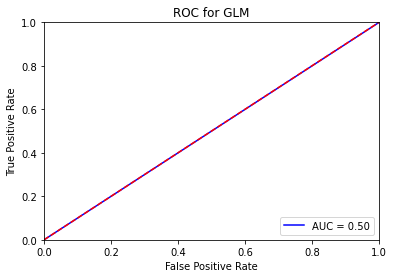

In [82]:
# get false positive/true positive rates
fpr, tpr, threshold = metrics.roc_curve(ytest, LRPred)

# get roc/auc measurements
glm_auc = roc_auc_score(ytest, LRPred)
print('GLM ROC AUC=%.3f' % (glm_auc))

# plot ROC/AUC
plt.title('ROC for GLM')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % glm_auc)
plt.legend(loc = 'lower right')

# plot a dotted line for the threshold
plt.plot([0, 1], [0, 1],'r--')

# set axes limits and labels
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Feature importance for GLM

To what degree did each column [feature] contribute to the final output? Let me check feature importance [code adapted from [here](https://machinelearningmastery.com/calculate-feature-importance-with-python/)]. 

In this case, the positive features are those that predict class 1 [CAD] whereas the negative ones predict feature 0 [CM]. Logistic regression feature importance plots are the only ones that look like this [the rest only have positive values]. 

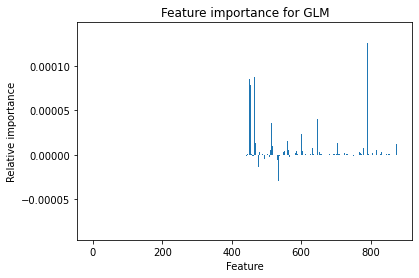

In [83]:
# get feature importance for GLM--i have to include the [0] because it's formatted as [[importance]]
importance = LR.coef_[0]
 
# visualize with bar plot
plt.bar([x for x in range(len(importance))], importance)
plt.title("Feature importance for GLM")
plt.xlabel("Feature")
plt.ylabel("Relative importance")
plt.show()

### GLM with boosting

We'll be using AdaBoost to potentially improve the performance of our GLM. We'll consider it to be a fairly weak classifier especially given the complexity of the data. The hope is that, by boosting, we'll be able to target points likely to have been misclassified by our non-boosting GLM and improve prediction accuracy. There's a nice description of AdaBoost [here](https://blog.paperspace.com/adaboost-optimizer/) as well as [here](https://codesachin.wordpress.com/tag/adaboost/). 

In [84]:
# set up the booster on the GLM classifier you previously made
LRAda = AdaBoostClassifier(LR)

# train the booster
LRAdaPred = LRAda.fit(xtrain, ytrain).predict(xtest)

# calculate the percent error--errors/(size of test set)*100
LRAdaerror = float(((LRAdaPred != ytest).sum())/len(xtest))*100

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


What was our error rate? [I'm printing this outside the previous code block because of all the "failed to converge" warnings]

In [85]:
print("With AdaBoost, we get an GLM error rate of {}%.".format(LRAdaerror))

With AdaBoost, we get an GLM error rate of 11.81215787957361%.


#### K-fold cross validation for GLM with boosting

This code is nearly identical to our previous k-fold runs. Yes -- one way to avoid this redundancy would have been to loop over the model names -- so in this case instead of hard-coding ```LRAda``` in ```cross_val_score(LRAda, model, lab, scoring='accuracy', cv=cv, n_jobs=-1)``` we could generate scores for each classifier and print them out next to their associated model name. 

One benefit of this approach is that a loop would rely on us having run each model beforehand, whereas here we can run each model to completion mostly independent of the others. This is helpful to save on runtime--of course boosting/majority vote rely on running other models, but if I just wanted to run the GLM and gather all its performance metrics I can do so here. 

In [86]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# get the task and associated labels
task = datasets[taskind]
lab = labels[taskind]

# evaluate model--n_jobs = -1 means to use all processors
# see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html 
LRAdascores = cross_val_score(LRAda, task, lab, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance--we take the average accuracy over all folds. 1- just gives us the error rate
print("The k-fold cross-validated error rate is " + str((1-np.mean(LRAdascores))*100)+ "%.")

The k-fold cross-validated error rate is 11.86990277325023%.


#### ROC/AUC measurements for GLM with boosting

Same code as previously. Again we could've looped over each trained model to avoid this redundancy, e.g. loop over ```LRAdaPred``` in ```metrics.roc_curve(ytest, LRAdaPred)``` and ```roc_auc_score(ytest, LRAdaPred)```. 

GLM with adaboost ROC AUC=0.504


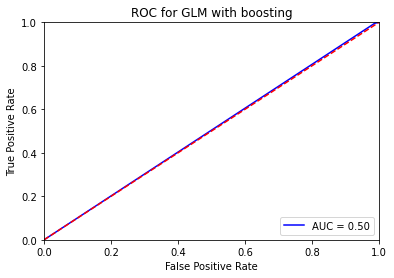

In [87]:
# get false positive/true positive rates
fpr, tpr, threshold = metrics.roc_curve(ytest, LRAdaPred)

# get roc/auc measurements
glm_ada_auc = roc_auc_score(ytest, LRAdaPred)
print('GLM with adaboost ROC AUC=%.3f' % (glm_ada_auc))

# plot ROC/AUC
plt.title('ROC for GLM with boosting')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % glm_ada_auc)
plt.legend(loc = 'lower right')

# plot a dotted line for the threshold
plt.plot([0, 1], [0, 1],'r--')

# set axes limits and labels
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Feature importance for GLM with boosting

We have not found a way to get this to work. Feature importance can be calculated for AdaBoost with a decision tree but we could not find an attribute of this classifier that displayed feature importance for us. The parameter we used to calculate feature importance for the GLM [```coef_```] is not present in the AdaBoostClassifier model type and the feature importance parameter it does have [```feature_importances_```] is not present in LogisticRegression model types. 

### Decision tree classification

This is a common approach used for binary classification so we'll try it out. Now, effective classification here is contingent on our model being able to identify high-quality rules it can use to split/classify our data. For a nice graphical description of decision trees in machine learning, I found [this](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052) site to be useful. 

You'll note that this code block looks very similar to the GLM code block. That will be the case for all non-boosting classifiers with the exception of majority vote [additionally the boosting code blocks looks nearly identical to one another]. As a result we won't be commenting too much on each individual code block. In terms of setup/implementation, they are all slightly different variations of the same general theme. 

In [88]:
# set up your decision tree 
dectree = tree.DecisionTreeClassifier()

# predict the test data's labels
decpred = dectree.fit(xtrain, ytrain).predict(xtest)

# compute the error
# number of errors
numDecError = (decpred != ytest).sum()

# calculate the percent error--errors/(size of test set)*100
decerror = float(numDecError/len(xtest))*100

# How many errors did we get?
print("Out of "+str(len(xtest))+" points, the decision tree produced "+str(numDecError)+" errors, resulting in an error rate of " + str(decerror)+"%.")

Out of 3471 points, the decision tree produced 642 errors, resulting in an error rate of 18.49611063094209%.


#### K-fold cross validation for decision tree

This code is nearly identical to our previous k-fold runs. 

In [89]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# get the task and associated labels
task = datasets[taskind]
lab = labels[taskind]

# evaluate model--n_jobs = -1 means to use all processors
# see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html 
decTreeScores = cross_val_score(dectree, task, lab, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance--we take the average accuracy over all folds. 1- just gives us the error rate
print("The k-fold cross-validated error rate is " + str((1-np.mean(decTreeScores))*100)+ "%.")

The k-fold cross-validated error rate is 17.947598938909547%.


#### ROC/AUC measurements for decision tree



Decision tree ROC AUC=0.572


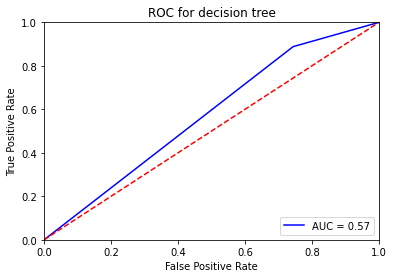

In [90]:
# get false positive/true positive rates
fpr, tpr, threshold = metrics.roc_curve(ytest, decpred)

# get roc/auc measurements
dectree_auc = roc_auc_score(ytest, decpred)
print('Decision tree ROC AUC=%.3f' % (dectree_auc))

# plot ROC/AUC
plt.title('ROC for decision tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % dectree_auc)
plt.legend(loc = 'lower right')

# plot a dotted line for the threshold
plt.plot([0, 1], [0, 1],'r--')

# set axes limits and labels
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Feature importance for decision tree

Same as the previous feature importance calculation. Code from [here](https://machinelearningmastery.com/calculate-feature-importance-with-python/)]. This would be less efficient to loop over as 1) not every model can produce feature importance plots like this and 2) they rely on different parameters to produce this output. 

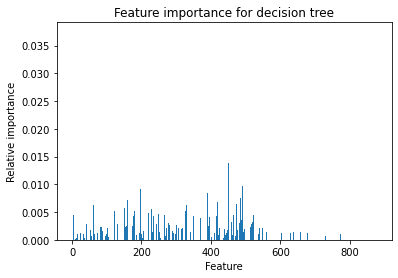

In [91]:
# get feature importance for decision tree
importance = dectree.feature_importances_

# visualize results w bar plot
plt.bar([x for x in range(len(importance))], importance)
plt.title("Feature importance for decision tree")
plt.xlabel("Feature")
plt.ylabel("Relative importance")
plt.show()

### Decision tree with boosting

Since AdaBoost is generally performed with decision trees, this is particularly salient to try out. 

In [92]:
# set up the booster on the decision tree classifier you already made
decAda = AdaBoostClassifier(dectree)

# fit it to the data
decAdaPred = decAda.fit(xtrain, ytrain).predict(xtest)

# calculate the percent error--errors/(size of test set)*100
decAdaerror = float((decAdaPred != ytest).sum()/len(xtest))*100

# What was the error?
print("With AdaBoost, we get an decision tree error rate of {}%.".format(decAdaerror))

With AdaBoost, we get an decision tree error rate of 18.49611063094209%.


#### K-fold cross validation for decision tree with boosting

In [108]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# get the task and associated labels
task = datasets[taskind]
lab = labels[taskind]

# evaluate model--n_jobs = -1 means to use all processors
# see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html 
decAdaTreeScores = cross_val_score(decAda, model, lab, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance--we take the average accuracy over all folds. 1- just gives us the error rate
print("The k-fold cross-validated error rate is " + str((1-np.mean(decAdaTreeScores))*100)+ "%.")

The k-fold cross-validated error rate is 17.740225735929638%.


#### ROC/AUC measurements for decision tree with boosting


Decision tree with adaboost ROC AUC=0.580


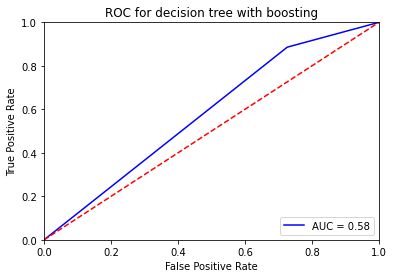

In [94]:
# get false positive/true positive rates
fpr, tpr, threshold = metrics.roc_curve(ytest, decAdaPred)

# get roc/auc measurements
decAda_auc = roc_auc_score(ytest, decAdaPred)
print('Decision tree with adaboost ROC AUC=%.3f' % (decAda_auc))

# plot ROC/AUC
plt.title('ROC for decision tree with boosting')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % decAda_auc)
plt.legend(loc = 'lower right')

# plot a dotted line for the threshold
plt.plot([0, 1], [0, 1],'r--')

# set axes limits and labels
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Feature importance for decision tree with boosting

To what degree did each column [feature] contribute to the final output? Let me check feature importance [from [here](https://machinelearningmastery.com/calculate-feature-importance-with-python/)]

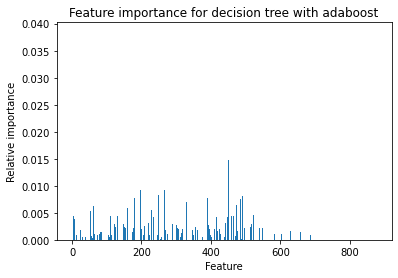

In [95]:
# get feature importance for decision tree
importance = decAda.feature_importances_

# visualize results w bar plot
plt.bar([x for x in range(len(importance))], importance)
plt.title("Feature importance for decision tree with adaboost")
plt.xlabel("Feature")
plt.ylabel("Relative importance")
plt.show()

### SVM classification

SVMs are a powerful tool and we hope that the kernel trick [some nice visualizations [here](https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f)] will work in our favor here, especially if the data is not linearly separable. Having said that, we are not optimizing for kernel choice here. As a result, these results aren't necessarily an indication that there exists some function that can transform our data into a space where it is linearly separable. 

In [96]:
# set up the svm
supportvm = svm.SVC()

# predict the test data's labels
svmpred = supportvm.fit(xtrain, ytrain).predict(xtest)

# compute the error
# number of errors
numSVMError = (svmpred != ytest).sum()

# calculate the percent error--errors/(size of test set)*100
svmerror = float(numSVMError/len(xtest))*100

# How many errors did we get?
print("Out of "+str(len(xtest))+" points, the SVM produced "+str(numSVMError)+" errors, resulting in an error rate of " + str(svmerror)+"%.")

Out of 3471 points, the SVM produced 402 errors, resulting in an error rate of 11.581676750216076%.


#### K-fold cross validation for SVM

In [97]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# get the task and associated labels
task = datasets[taskind]
lab = labels[taskind]

# evaluate model--n_jobs = -1 means to use all processors
# see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html 
svmScores = cross_val_score(supportvm, task, lab, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance--we take the average accuracy over all folds. 1- just gives us the error rate
print("The k-fold cross-validated error rate is " + str((1-np.mean(svmScores))*100)+ "%.")

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


The k-fold cross-validated error rate is 11.619179778271583%.


#### ROC/AUC measurements for SVM

SVM ROC AUC=0.501


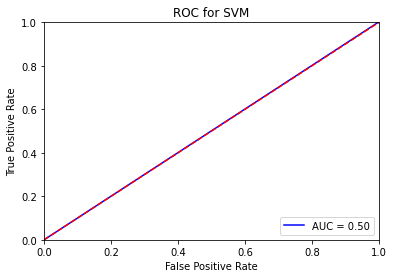

In [98]:
# get false positive/true positive rates
fpr, tpr, threshold = metrics.roc_curve(ytest, svmpred)

# get roc/auc measurements
svm_auc = roc_auc_score(ytest, svmpred)
print('SVM ROC AUC=%.3f' % (svm_auc))

# plot ROC/AUC
plt.title('ROC for SVM')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % svm_auc)
plt.legend(loc = 'lower right')

# plot a dotted line for the threshold
plt.plot([0, 1], [0, 1],'r--')

# set axes limits and labels
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Feature importance for SVM

Unfortunately the only SVM setting that produces feature importance measurements is a linear kernel. Linear kernels take prohibitively long to run so we're not using them here. Since the separating hyperplane used by a nonlinear-kernel SVM acts on a transformed feature space not drectly related to the input, it doesn't make sense to calculate feature importance. For more information see [here](https://stackoverflow.com/questions/21260691/how-to-obtain-features-weights).

## Ensemble classification approaches

Perhaps ensemble classification approaches can leverage the power of multiple classifiers to produce a consensus classifcation that outperforms our other models. We'll use two standard approaches -- random forest and a majority vote combining all previous classifiers. 

Yes, AdaBoost is an ensemble classification approach. Since we were using it with a non-ensemble classifier that we had run, however, we left it in the section above. 

### Random forest classification

This has some superficial similarities with our "AdaBoost with decision tree" approach as it uses an ensemble of decision trees to classify. The difference is in the way those decision trees are utilized to facilitate that classification. There is a nice description of random forest [here](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) along with some images. 

In [99]:
# set up your random forest--I'll try these default parameters and see if I need to tune them
randomforest = RandomForestClassifier(n_estimators = 50, max_depth = None, random_state = 10, max_features = 'auto')

# predict the test data's labels
rfpred = randomforest.fit(xtrain, ytrain).predict(xtest)

# calculate the percent error--errors/(size of test set)*100
numRFError = (rfpred != ytest).sum()
rferror = float(numRFError/len(xtest))*100

# How many errors did we get?
print("Out of "+str(len(xtest))+" points, the random forest produced "+str(numRFError)+" errors, resulting in an error rate of " + str(rferror)+"%.")

Out of 3471 points, the random forest produced 397 errors, resulting in an error rate of 11.437626044367617%.


#### K-fold cross validation for random forest

In [100]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# get the task and associated labels
task = datasets[taskind]
lab = labels[taskind]

# evaluate model--n_jobs = -1 means to use all processors
# see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html 
rfScores = cross_val_score(randomforest, task, lab, scoring='accuracy', cv=cv, n_jobs=-1)

#report performance--we take the average accuracy over all folds. 1- just gives us the error rate
print("The k-fold cross-validated error rate is " + str((1-np.mean(rfScores))*100)+ "%.")

The k-fold cross-validated error rate is 11.325338768381421%.


#### ROC/AUC measurements for random forest

Random forest ROC AUC=0.515


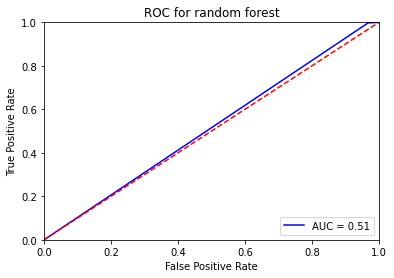

In [101]:
# get false positive/true positive rates
fpr, tpr, threshold = metrics.roc_curve(ytest, rfpred)

# get roc/auc measurements
rf_auc = roc_auc_score(ytest, rfpred)
print('Random forest ROC AUC=%.3f' % (rf_auc))

# plot ROC/AUC
plt.title('ROC for random forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % rf_auc)
plt.legend(loc = 'lower right')

# plot a dotted line for the threshold
plt.plot([0, 1], [0, 1],'r--')

# set axes limits and labels
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Feature importance for random forest

To what degree did each column [feature] contribute to the final output? Let me check feature importance [from [here](https://machinelearningmastery.com/calculate-feature-importance-with-python/)]

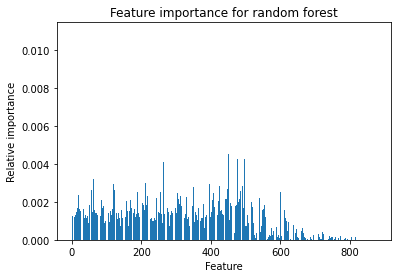

In [102]:
# get feature importance for random forest
importance = randomforest.feature_importances_

# visualize results w bar plot
plt.bar([x for x in range(len(importance))], importance)
plt.title("Feature importance for random forest")
plt.xlabel("Feature")
plt.ylabel("Relative importance")
plt.show()

### Majority vote classification

We'll just take all our previous models [GLM, GLM+adaboost, decision tree, decision tree+adaboost, SVM and random forest] and produce an ensemble -- see if that improves performance. 


As a small note -- we did try a "soft" voting approach [predicts class based on _argmax(sum(predicted class probabilities))_ ] but found that it did not execute properly, so we use "hard" voting here. 

In [103]:
# set up the majority vote from all our previous models [without adaboost]
# "hard" voting just means that we predict the label for each data point using the labels from each constituent classifier
majvote = VotingClassifier(estimators=[('glm', LR), ('LA', LRAda), ('dt', dectree), ('da', decAda), ('svm', supportvm), ('rf', randomforest)], voting='hard')

# predict the test data's labels
majpred = majvote.fit(xtrain, ytrain).predict(xtest)

# calculate the percent error--errors/(size of test set)*100
majerror = ((majpred != ytest).sum()/len(xtest))*100

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


What's our error rate?

In [104]:
# How many errors did we get?
print("Out of "+str(len(xtest))+" points, the majority vote produced "+str((majpred != ytest).sum())+" errors, resulting in an error rate of " + str(majerror)+"%.")

Out of 3471 points, the majority vote produced 403 errors, resulting in an error rate of 11.610486891385769%.


#### K-fold cross validation for majority vote

In [107]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# get the task and associated labels
task = datasets[taskind]
lab = labels[taskind]

# evaluate model--n_jobs = -1 means to use all processors
# see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html 
rfScores = cross_val_score(majvote, taskind, lab, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance--we take the average accuracy over all folds. 1- just gives us the error rate
print("The k-fold cross-validated error rate is " + str((1-np.mean(rfScores))*100)+ "%.")

The k-fold cross-validated error rate is 11.472233104945673%.


#### ROC/AUC measurements for majority vote


Majority vote: ROC AUC=0.506


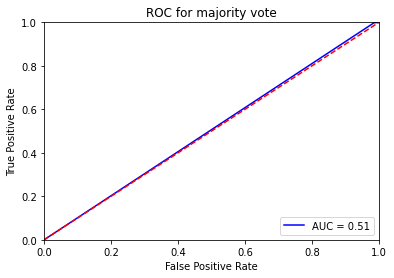

In [109]:
# get false positive/true positive rates
fpr, tpr, threshold = metrics.roc_curve(ytest, majpred)

# get roc/auc measurements
majvote_auc = roc_auc_score(ytest, majpred)
print('Majority vote: ROC AUC=%.3f' % (majvote_auc))

# plot ROC/AUC
plt.title('ROC for majority vote')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % majvote_auc)
plt.legend(loc = 'lower right')

# plot a dotted line for the threshold
plt.plot([0, 1], [0, 1],'r--')

# set axes limits and labels
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Feature importance for majority vote

We couldn't find a way to calculate feature importance here. Additionally, since we are using a SVM with nonlinear kernel as part of the majority voter it doesn't make much sense to do so anyway. 

## Analyzing data structure and labels from the non-text LABEVENTS data matrix

We wanted to take a look at the data matrix structure to understand why its performance was so poor. We thought that it may have been due to a large amount of NA values throughout the matrix. Coupled with our imputation procedure [substitute NA with column mean] it seems that the LABEVENTS data is not very effective at classifying. 


### Looking at NA values throughout the matrix

We noticed that our non-text matrix has a lot of NA values. We calculated  the percent of non-NA values by column as a result -- we realized that a lot of values are either all-NA or are nearly all-NA. This is a caveat of our work! When we fill NA values with the mean from each column it looks like, in the case of many columns, those means are based on a small fraction of values and most of the column consists of these imputed values. 

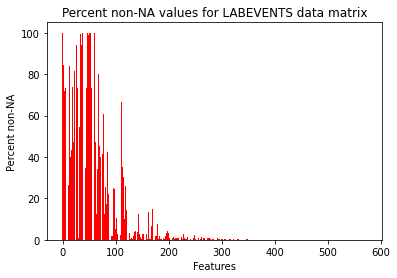

In [77]:
# looks like all the rows have na values somewhere...so we'll have to deal with that
n = nontext.dropna()

# figure out the % of non-NAs per column and plot it
# see here https://stackoverflow.com/questions/22257527/how-do-i-get-a-summary-count-of-missing-nan-data-by-column-in-pandas

# calculate % non-NA [hence the 1-]
nacount = (1-(nontext.isnull().sum()/len(nontext)))*100

# plot as a bar chart
plt.bar([x for x in range(len(nacount))], nacount, color="r")
plt.xlabel("Features")
plt.ylabel("Percent non-NA")
plt.title("Percent non-NA values for LABEVENTS data matrix")
plt.show()